In [1]:
%pip install supervision ultralytics rasterio

     ---------------------------------------- 0.0/41.2 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.2 kB ? eta -:--:--
     ------------------ ------------------- 20.5/41.2 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 41.2/41.2 kB 329.5 kB/s eta 0:00:00
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
  Using cached pandas-2.2.2-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/135.7 kB ? eta -:--:--
   ---------------------------------------  133.1/135.7 kB


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install pillow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import os
folders = [
    'raw_inputs',
    'images/train',
    'images/test',
    'labels/train',
    'labels/test',
    'sub_images'
]
for folder in folders:
    os.makedirs(folder, exist_ok=True)

Covert Tif to JPG

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ankik\AppData\Local\Temp\ipykernel_6720\2583431444.py:7: SyntaxWarning: invalid escape sequence '\i'
  with rasterio.open("raw_inputs\image.tif") as src:


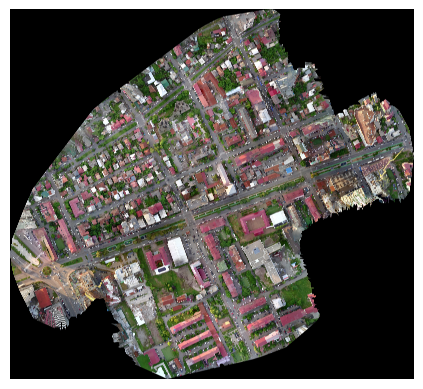

In [22]:
import rasterio
from rasterio.plot import reshape_as_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("raw_inputs\image.tif") as src:
    # read RGB bands
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)

    rgb_composite_n = np.dstack((red, green, blue))

    plt.imshow(rgb_composite_n)
    plt.axis('off')
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    dpi = 2400
    plt.savefig(f"raw_inputs/image.jpg", dpi=dpi,
                bbox_inches='tight', pad_inches=0)

Split the images

In [23]:
from PIL import Image
parameter = 15

# Read the image
img = Image.open('raw_inputs\image.jpg')

# Get Dims of the image
width, height = img.size

sub_width = width // parameter
sub_height = height // parameter

# Loop through each sub-image and save it
for i in range(parameter):
    for j in range(parameter):
        left = j * sub_width
        top = i * sub_height
        right = left + sub_width
        bottom = top + sub_height
        sub_img = img.crop((left, top, right, bottom))

        sub_img.save(f'sub_images/sub_image_{i}_{j}.jpg')

<>:5: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ankik\AppData\Local\Temp\ipykernel_6720\3594932199.py:5: SyntaxWarning: invalid escape sequence '\i'
  img = Image.open('raw_inputs\image.jpg')


Label Vehicles in Sub-images

In [24]:
import shutil
import os

folder_name = 'sub_images'
zip_file_name = f'{folder_name}.zip'

# Create a zip file
shutil.make_archive(folder_name, 'zip', folder_name)

# Output path where the zip file is saved
zip_file_path = os.path.abspath(zip_file_name)

# Print the path for user reference
print(f'ZIP file created at: {zip_file_path}')

# Note: Downloading is not necessary in local environment, the file is saved locally.

ZIP file created at: d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images.zip


Convert COCO JSON to TXT

In [29]:
import json
import os

# Function to convert COCO bounding box to YOLO format
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2] / 2.0) * dw
    y = (box[1] + box[3] / 2.0) * dh
    w = box[2] * dw
    h = box[3] * dh
    return (x, y, w, h)

def convert_coco_to_yolo(coco_json_path, output_dir):
    with open(coco_json_path) as f:
        data = json.load(f)

    images = {img['id']: img for img in data['images']}
    categories = {cat['id']: cat for cat in data['categories']}

   

    # Create a mapping from category ids to their corresponding YOLO class ids
    category_mapping = {cat_id: idx for idx, cat_id in enumerate(categories.keys())}

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']

        image_info = images[image_id]
        image_width = image_info['width']
        image_height = image_info['height']

        yolo_bbox = convert_bbox((image_width, image_height), bbox)

        # Create or append to the corresponding YOLO format file for this image
        yolo_file_path = os.path.join(output_dir, f"{image_info['file_name'].split('.')[0]}.txt")

        with open(yolo_file_path, 'a') as yolo_file:
            yolo_file.write(f"{category_mapping[category_id]} {' '.join(map(str, yolo_bbox))}\n")

coco_json_path = 'raw_inputs/labels_my-project-name_2024-07-17-12-51-48.json'
output_dir = 'raw_inputs'
convert_coco_to_yolo(coco_json_path, output_dir)

Prepare and Test Database

Now that we have the sub-images along with the label TXT files (bounding boxes around each car), we can split them into training and testing datasets. We previously created two folders, images and labels, each containing train and test subfolders, but all of them are currently empty. The following function will randomly select 75% of the images from the sub_images folder along with their corresponding TXT files and place them in images/train and labels/train, respectively. The remaining 25% will be placed in images/test and labels/test:

In [30]:
import os
import random
import shutil

def split_files(source_folder, labels_train_folder, labels_test_folder, images_train_folder, images_test_folder, train_ratio=0.75):
    
    # List all txt files starting with sub_image_
    txt_files = [f for f in os.listdir(source_folder) if f.startswith('sub_image_') and f.endswith('.txt')]
    
    # Shuffle the list
    random.shuffle(txt_files)
    
    split_index = int(len(txt_files) * train_ratio)
    
    # Split into training and testing sets
    train_files = txt_files[:split_index]
    test_files = txt_files[split_index:]
    
    
    for txt_file in train_files:
        # Move txt file
        shutil.move(os.path.join(source_folder, txt_file), os.path.join(labels_train_folder, txt_file))
        # Replace .txt with .jpg and move them
        jpg_file = txt_file.replace('.txt', '.jpg')
        if os.path.exists(os.path.join(source_folder_image, jpg_file)):
            shutil.copy(os.path.join(source_folder_image, jpg_file), os.path.join(images_train_folder, jpg_file))
    
    for txt_file in test_files:
        # Move txt file
        shutil.move(os.path.join(source_folder, txt_file), os.path.join(labels_test_folder, txt_file))
        # Replace .txt with .jpg and move them
        jpg_file = txt_file.replace('.txt', '.jpg')
        if os.path.exists(os.path.join(source_folder_image, jpg_file)):
            shutil.copy(os.path.join(source_folder_image, jpg_file), os.path.join(images_test_folder, jpg_file))

source_folder = 'raw_inputs'
source_folder_image ='sub_images'
labels_train_folder = 'labels/train'
labels_test_folder = 'labels/test'
images_train_folder = 'images/train'
images_test_folder = 'images/test'

split_files(source_folder, labels_train_folder, labels_test_folder, images_train_folder, images_test_folder, train_ratio=0.75)

Train YOLO

In [31]:
import yaml
data = {'train': 'images/train',
'val': 'images/test',
'nc': 1,
'names': ['car']
}

# Write the yaml file
with open('yolo_config.yaml', 'w') as file:
    yaml.dump(data, file)

In [33]:
from ultralytics import YOLO
import yaml
import torch
from PIL import Image
import os
import cv2
import time

# Choose the config
yaml_filename = 'yolo_config.yaml'

# Create Yolo model
model = YOLO('yolov8m.yaml').load('yolov8m.pt')

# Train the model
model.train(data=f'{yaml_filename}', epochs=30)

Transferred 475/475 items from pretrained weights
Ultralytics YOLOv8.2.58  Python-3.12.3 torch-2.3.1+cpu CPU (Intel Pentium Gold G6400 4.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8m.yaml, data=yolo_config.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 5.55MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             


  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384, 576, 3, 2]              
  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning D:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\labels\train... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 48.00it/s]

train: New cache created: D:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\labels\train.cache



val: Scanning D:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\labels\test... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 97.93it/s]

val: New cache created: D:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\labels\test.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.666      3.746      2.087        203        640: 100%|██████████| 1/1 [02:12<00:00, 132.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:22<00:00, 22.53s/it]

                   all          5         73      0.014      0.288     0.0117    0.00301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      2.686      3.855      1.796        311        640: 100%|██████████| 1/1 [02:09<00:00, 129.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<00:00, 21.57s/it]

                   all          5         73     0.0307       0.63     0.0668     0.0186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      2.634       3.38      1.908        245        640: 100%|██████████| 1/1 [02:09<00:00, 129.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 20.14s/it]

                   all          5         73      0.676      0.438       0.59      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      2.475      2.543      1.699        208        640: 100%|██████████| 1/1 [02:11<00:00, 131.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<00:00, 21.81s/it]

                   all          5         73      0.777      0.822      0.894      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      2.315      1.575      1.881        205        640: 100%|██████████| 1/1 [02:05<00:00, 125.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.69s/it]

                   all          5         73      0.839      0.925      0.947      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.885      1.285       1.43        361        640: 100%|██████████| 1/1 [02:14<00:00, 134.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<00:00, 21.39s/it]

                   all          5         73      0.783      0.932      0.946      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.766      1.415      1.476        228        640: 100%|██████████| 1/1 [02:09<00:00, 129.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<00:00, 21.72s/it]

                   all          5         73      0.714      0.945      0.924      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.654      1.092      1.382        217        640: 100%|██████████| 1/1 [02:05<00:00, 125.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.97s/it]

                   all          5         73      0.718      0.904      0.877        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.533      1.259      1.455        194        640: 100%|██████████| 1/1 [02:00<00:00, 120.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 20.01s/it]

                   all          5         73      0.734      0.905      0.893      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.785      1.235      1.342        283        640: 100%|██████████| 1/1 [02:05<00:00, 125.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 21.00s/it]

                   all          5         73      0.835      0.902      0.923      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G       1.54     0.9985      1.418        202        640: 100%|██████████| 1/1 [02:10<00:00, 130.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:19<00:00, 19.79s/it]

                   all          5         73      0.787       0.96      0.955      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.429     0.8271      1.388        213        640: 100%|██████████| 1/1 [02:51<00:00, 171.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.06s/it]

                   all          5         73      0.851      0.973      0.968      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.506      1.288      1.432        138        640: 100%|██████████| 1/1 [02:29<00:00, 149.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.26s/it]

                   all          5         73      0.883      0.973      0.975      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.407     0.8897      1.332        141        640: 100%|██████████| 1/1 [02:26<00:00, 146.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:24<00:00, 24.28s/it]

                   all          5         73       0.91      0.968      0.968      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.397     0.8143      1.178        331        640: 100%|██████████| 1/1 [02:48<00:00, 168.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:22<00:00, 22.61s/it]

                   all          5         73      0.877      0.973      0.951      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.376     0.8014      1.226        220        640: 100%|██████████| 1/1 [02:47<00:00, 167.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.67s/it]

                   all          5         73      0.926      0.945      0.972       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.321     0.7624      1.102        369        640: 100%|██████████| 1/1 [02:29<00:00, 149.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.54s/it]

                   all          5         73      0.927      0.959      0.981      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.396     0.7567      1.261        158        640: 100%|██████████| 1/1 [02:26<00:00, 146.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.73s/it]

                   all          5         73      0.927      0.959      0.981      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.315     0.6082      1.213        232        640: 100%|██████████| 1/1 [02:38<00:00, 158.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.67s/it]

                   all          5         73      0.934      0.977      0.986      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.343     0.6225      1.225        274        640: 100%|██████████| 1/1 [02:13<00:00, 133.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.74s/it]

                   all          5         73      0.934      0.977      0.986      0.648


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.373     0.9276       1.48        136        640: 100%|██████████| 1/1 [02:22<00:00, 142.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:24<00:00, 24.10s/it]

                   all          5         73      0.911      0.986       0.98      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.194     0.7093      1.162        150        640: 100%|██████████| 1/1 [02:24<00:00, 144.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.34s/it]

                   all          5         73      0.911      0.986       0.98      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G        1.2     0.7247      1.106        153        640: 100%|██████████| 1/1 [02:20<00:00, 140.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:22<00:00, 22.25s/it]

                   all          5         73       0.91      0.973      0.978      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.257      0.637      1.271        140        640: 100%|██████████| 1/1 [02:20<00:00, 140.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.64s/it]

                   all          5         73       0.91      0.973      0.978      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.131     0.6275      1.178        136        640: 100%|██████████| 1/1 [02:23<00:00, 143.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:22<00:00, 22.37s/it]

                   all          5         73      0.958      0.931      0.982      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.191     0.5948      1.204        143        640: 100%|██████████| 1/1 [02:11<00:00, 131.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:22<00:00, 22.13s/it]

                   all          5         73      0.958      0.931      0.982      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.173     0.6345      1.239        137        640: 100%|██████████| 1/1 [02:23<00:00, 143.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:22<00:00, 22.72s/it]

                   all          5         73      0.958      0.932      0.982      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.161     0.6004      1.267        132        640: 100%|██████████| 1/1 [02:19<00:00, 139.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:25<00:00, 25.72s/it]

                   all          5         73      0.958      0.932      0.982      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.211     0.5952      1.223        142        640: 100%|██████████| 1/1 [02:20<00:00, 140.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:25<00:00, 25.29s/it]

                   all          5         73      0.935      0.977      0.982      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.177      0.567      1.206        144        640: 100%|██████████| 1/1 [02:17<00:00, 137.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:23<00:00, 23.73s/it]

                   all          5         73      0.935      0.977      0.982      0.649



30 epochs completed in 1.410 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 52.0MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.58  Python-3.12.3 torch-2.3.1+cpu CPU (Intel Pentium Gold G6400 4.00GHz)
YOLOv8m summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:20<00:00, 20.81s/it]


                   all          5         73      0.934      0.977      0.986      0.645
Speed: 9.0ms preprocess, 4130.6ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002AF3CDE2870>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [35]:
# Load the trained weights
model = YOLO('runs/detect/train2/weights/best.pt')

# Run prediction 
im_dir = 'sub_images/'
results = model.predict(source=im_dir, save=True, conf=0.9)


total_cars = 0

# Iterate over the results to count the number of cars
for result in results:
    # Count the number of detections
    total_cars += len(result.boxes)

print(f'Total number of cars detected: {total_cars}')

with open('total_cars.txt', 'w') as f:
    f.write(f'Total number of cars detected: {total_cars}\n')


image 1/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_0.jpg: 608x640 (no detections), 4561.3ms
image 2/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_1.jpg: 608x640 (no detections), 5150.8ms
image 3/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_10.jpg: 608x640 (no detections), 4849.2ms
image 4/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_11.jpg: 608x640 (no detections), 5109.2ms
image 5/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_12.jpg: 608x640 (no detections), 4309.6ms
image 6/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_13.jpg: 608x640 (no detections), 3621.9ms
image 7/225 d:\OneDrive\Programming\Github\Car-Detection-using-YOLOv8\sub_images\sub_image_0_14.jpg: 608x640 (no detections), 3963.0ms
image 8/225 d:\OneDrive\Programming\Github\Car-Detection